# **Data Visualization**

<p style="text-align: center;">
    <img style="width: 35%; height: 20%; float: left;" src="../assets/images/data_visualization.jpg" alt="Data Visualization image">
</p>

## Objectives

* Accomplish first business requirement:

  _**"The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew."**_

## Inputs Required

* Image data will be sourced from the following directories and their subfolders:

  - **Training Images**: inputs/cherry_leaves_dataset/cherry-leaves/train
  - **Validation Images**: inputs/cherry_leaves_dataset/cherry-leaves/validation
  - **Test Images**: inputs/cherry_leaves_dataset/cherry-leaves/test

## Generated Outputs

1. Embeddings for Image Shapes.
2. Average and variability of images per label plot.
3. Plot to distinguish the contrast between healthy leaves and ones infected with powdery mildew.
4. Generate code that satisfies business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

---

# Set up the working environment

## Import libraries

In [1]:
import os
import joblib
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image
sns.set_style("white")
print("\033[92mLibraries Imported Successfully!\033[0m")

Libraries Imported Successfully!


# Change working directory

* To maintain a straightforward folder structure for the application, we must navigate from the current folder to its parent folder by using `os.getcwd()` to access the current directory.

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves/jupyter_notebooks'

* To update the current directory to its parent directory, follow these steps:

  * Use `os.path.dirname()` to obtain the parent directory.
  * Utilize `os.chdir()` to set the new current directory to the parent directory.

In [3]:
os.chdir(os.path.dirname(current_dir))
print(f"\033[92mYou set a new current directory!\033[0m")

You set a new current directory!


* Confirm the new current directory.

In [4]:
new_current_dir = os.getcwd()
new_current_dir

'/workspaces/mildew-detection-in-cherry-leaves'

# Set input and output directory paths

**Inputs**

In [5]:
data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = data_dir + '/train'
validation_path = data_dir + '/validation'
test_path = data_dir + '/test'

**Outputs**

In [6]:
version = 'V_1'

file_path = f'outputs/{version}'
version_file_path = os.path.join(new_current_dir, file_path)

if os.path.exists(version_file_path):
    # check version file path exists, if not creates a new directory.
     print(f"\033[91mVersion {version} already exists. Create a new version please! \033[0m")
     pass
else:
    os.makedirs(name=file_path)
    print(f"\033[92mVersion {version} created successfully! \033[0m")

Version V_1 already exists. Create a new version please! 


# Set label names

In [7]:
labels = os.listdir(train_path)
print('Labels for the images are:', labels)

Labels for the images are: ['healthy', 'powdery_mildew']


---

# Data Visualization of image data 

## Average image shape (width, height) in pixels (px)
  * Note: The terms "average" and "mean" will be used interchangeably.

Width average: 256 px 
Height average: 256 px 



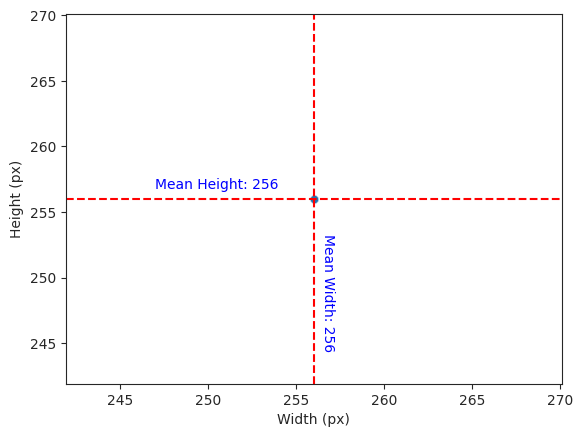

In [11]:
# Initialize two empty lists to store image dimensions
width, height = [], []

# Iterate through labels and image files in train dataset dir
for label in labels:
    for image_filename in os.listdir(os.path.join(train_path, label)):
        img = imread(os.path.join(train_path, label, image_filename))
        h, w, colors = img.shape # read each image shape
        height.append(h) # image height
        width.append(w) # iamge width

# Compute average/mean for each dimesnsion w, h
height_mean = int(np.array(height).mean())
width_mean = int(np.array(width).mean())

# Create plot of average image shape
sns.set_style('ticks')
fig, axes = plt.subplots()
sns.scatterplot(x=width, y=height, alpha=0.5)
axes.set_xlabel('Width (px)')
axes.set_ylabel('Height (px)')
axes.axvline(x=width_mean, color='r', linestyle='--')
axes.axhline(y=height_mean, color='r', linestyle='--')
axes.annotate(f'Mean Height: {height_mean}', (width_mean, height_mean), xytext=(-25, 15),
              textcoords='offset points', color='b', ha='right', va='top')
axes.annotate(f'Mean Width: {width_mean}', (width_mean, height_mean), xytext=(5, -25),
              textcoords='offset points', color='b', ha='left', va='top', rotation=270)
plt.show
print(f"Width average: \033[1m{width_mean} px\033[0m \nHeight average: \033[1m{height_mean} px\033[0m \n")


**Interpretation & Insights:**

* In the plot, the blue dot positioned at the intersection of the two red dashed lines represents the average image shape: (256, 256, 3) 
* The horizontal red dashed line signifies the mean height of the images, which is 256 pixels.
* Additionally, the vertical red dashed line corresponds to the mean width of the images, also measuring 256 pixels.

This visualization offers insights into the distribution of image dimensions within the dataset. This information aids in understanding the typical dimensions of images and potential variations in the dataset's contents.

In [9]:
av_image_shape = (height_mean, width_mean, colors)
print(f'\033[1mAverage image shape is: {av_image_shape}\033[0m')

Average image shape is: (256, 256, 3)


Save the image shape in a pkl file.

In [10]:
joblib.dump(value=av_image_shape, filename=f"{file_path}/av_image_shape.pkl")

['outputs/V_1/av_image_shape.pkl']

---

# Average and variability of images per label

Resizing images to a fixed shape and normalizing pixel values are essential preprocessing steps that significantly enhance the performance, stability, and efficiency of deep learning models. These processes ensure that all images have consistent dimensions, which allows the model to handle inputs of the same size during training and inference. Normalizing pixel values to a common range, typically (0, 1), prevents features with larger magnitudes from dominating the learning process and helps the model converge faster. These preprocessing techniques not only improve the model's ability to generalize across different image sizes but also enhance its capability to learn meaningful patterns from the data.

## Load and preprocess image data from a directory into numpy arrays

In [12]:
def load_image_as_array(data_dir, new_size=(50, 50), n_images_per_label=20):
    """
    This function prepares the image data for machine learning tasks, making it easier to train models.
    It uses Python lists and iterate each label in data directory, reshape images to a new size
    and save them to a numpy array.

    """
    X_list, y_list = [], []
    labels = os.listdir(data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(os.path.join(data_dir, label)):
            # Limit the number of images per label to reduce processing time
            if counter < n_images_per_label:
                # Load and resize the image
                img = image.load_img(os.path.join(data_dir, label, image_filename), target_size=new_size)

                # Normalize the pixel values to between 0 and 1
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                # Append the image and label to the lists
                X_list.append(img_resized)
                y_list.append(label)
                counter += 1

    # Convert lists to NumPy arrays
    X = np.array(X_list)
    y = np.array(y_list)

    return X, y

Load image shapes and labels into an array

In [13]:
X, y = load_image_as_array(data_dir=train_path,
                           new_size=av_image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


## Plot the mean and variability of images per label

In [14]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The function loops over all unique labels in y, calculates the mean and standard deviation of the images 
    belonging to each label and plots them in a figure.
    """
    # iterate over unique labels in y
    for label_to_display in np.unique(y):
        sns.set_style("white")
        # create a boolean mask that selects images with the current label
        y_copy = y.reshape(-1, 1, 1)  # Create a copy of y for reshaping
        boolean_mask = np.any(y_copy == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        # compute the average and standard deviation image for the selected images
        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)

        # plot the average and standard deviation images side by side
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        # optionally save the image to a file
        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")
            

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


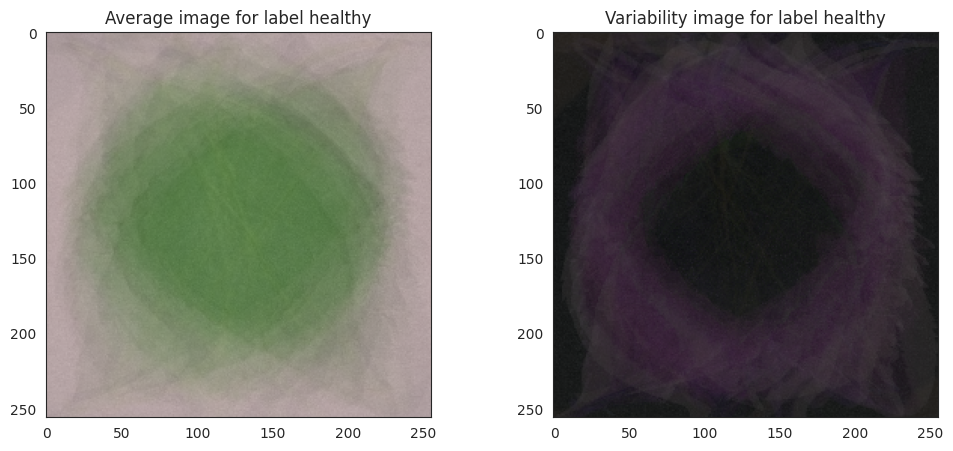

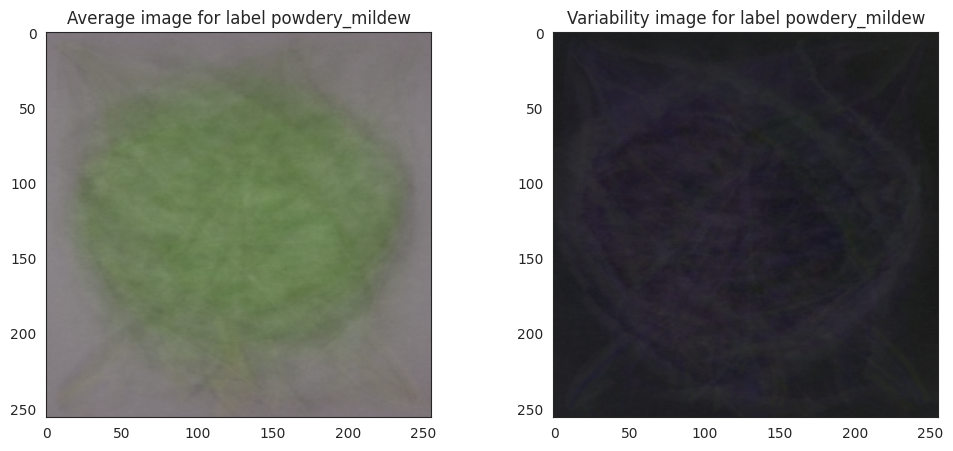

In [15]:
plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=True)